### Imports, setting matplotlib output and chart style

Make sure that you have installed `homeassistant`, `sqlalchemy` and `pandas` (`$ pip3 install homeassistant sqlalchemy pandas`) to use this notebook.

In [1]:
%matplotlib inline
from sqlalchemy import create_engine, text
from sqlalchemy.orm import scoped_session, sessionmaker
import json
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

from homeassistant.components.recorder.models import Base, Events, States, RecorderRuns

# Setting up a visual style for PyPlot, much better than the standard
plt.style.use('fivethirtyeight')

# Your database URL as specified in configuration.yaml
# If using default settings, it's sqlite:///<path to config dir>/home-assistant_v2.db
DB_URL = "sqlite:////path/.homeassistant/home-assistant_v2.db"

In [3]:
# Database setup
engine = create_engine(DB_URL)
Base.metadata.create_all(engine)
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)

### Basic query against the local database

In [4]:
# Let's query the states table of our database, get a list of entities \
# and number of statuses they've created
list(engine.execute("SELECT entity_id, COUNT(*) FROM states GROUP BY entity_id ORDER by 2 DESC"))

[('sensor.cpu_speed', 7),
 ('sensor.hello', 7),
 ('sensor.humidity', 7),
 ('sensor.load_15m', 7),
 ('sensor.load_1m', 7),
 ('sensor.load_5m', 7),
 ('sensor.memory_free', 7),
 ('sensor.memory_use', 7),
 ('sensor.temperature_in', 7),
 ('sensor.temperature_out', 7),
 ('sun.sun', 4),
 ('sensor.memory_use_percent', 3),
 ('automation.new_automation', 2),
 ('group.all_automations', 2),
 ('configurator.ikea_tradfri', 1),
 ('counter.counter', 1),
 ('counter.counter2', 1),
 ('fan.ceiling_fan', 1),
 ('fan.living_room_fan', 1),
 ('group.all_fans', 1),
 ('group.all_lights', 1),
 ('group.all_scripts', 1),
 ('input_boolean.switch1', 1),
 ('input_boolean.switch2', 1),
 ('input_number.manual_meter_input', 1),
 ('input_number.slider1', 1),
 ('input_text.command', 1),
 ('input_text.dummy_tiles', 1),
 ('light.bathroom', 1),
 ('light.mqtt_json_light_1', 1),
 ('light.nachtlicht', 1),
 ('script.cancel_timer', 1),
 ('script.finish_timer', 1),
 ('script.pause_timer', 1),
 ('script.press_button', 1),
 ('script.

### Executing our query, reading output into a Pandas DataFrame, plotting and formatting the output

Text(0,0.5,'Entity name')

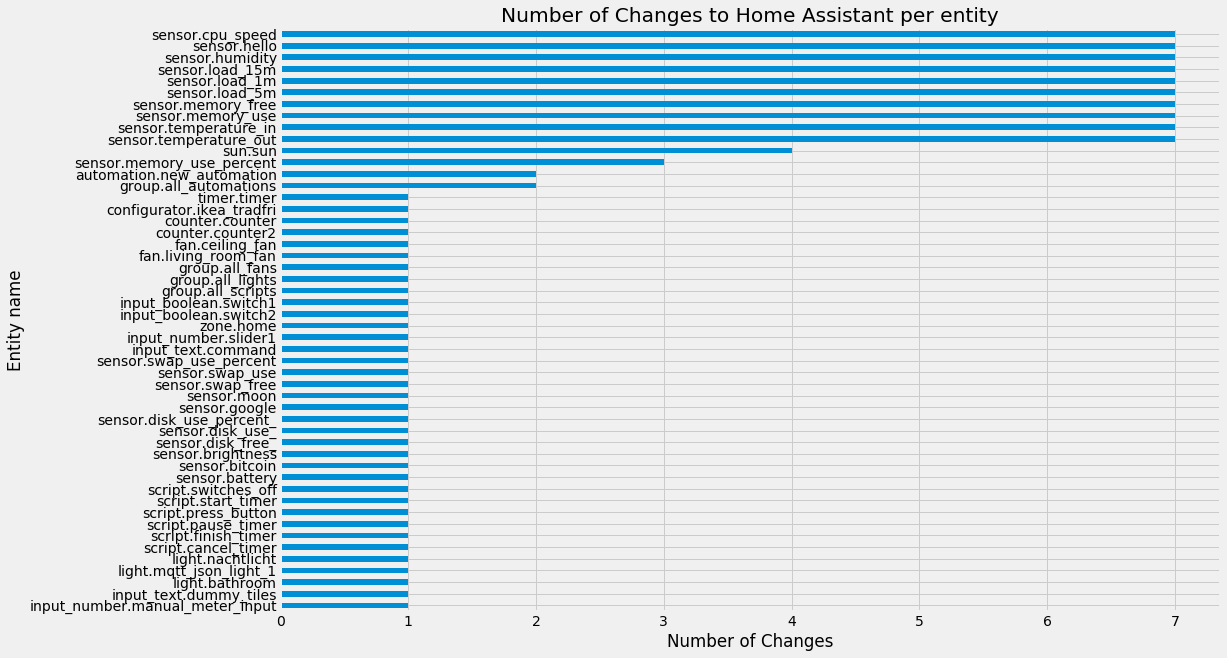

In [5]:
# Executing our SQL query against the database and storing the output
entityquery = engine.execute("SELECT entity_id, COUNT(*) FROM states GROUP BY entity_id ORDER by 2 DESC")

# Fetching th equery reults and reading it into a DataFrame
entitycallsDF = pd.DataFrame(entityquery.fetchall())

# Naming the dataframe columns
entitycallsDF.columns = ['entity', 'Number of Changes']

# Setting the entity name as an index of a new dataframe and sorting it
# by the Number of Changes
ordered_indexed_df = entitycallsDF.set_index(
    ['entity']).sort_values(by='Number of Changes')

# Displaying the data as a horizontal bar plot with a title and no legend
changesplot = ordered_indexed_df.plot(
    kind='barh', title='Number of Changes to Home Assistant per entity',
    figsize=(15, 10), legend=False)

# specifying labels for the X and Y axes
changesplot.set_xlabel('Number of Changes')
changesplot.set_ylabel('Entity name')

### How about plotting the status changes by day for every entity? 

[nan '°C' '%' 'MiB' 'GiB' '' 'GHz' 'USD']


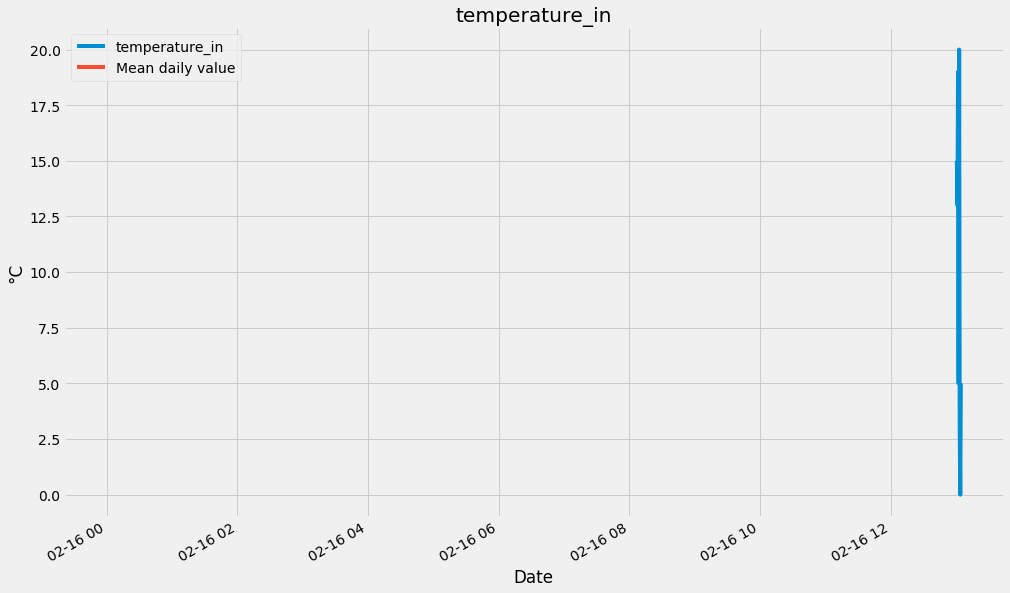

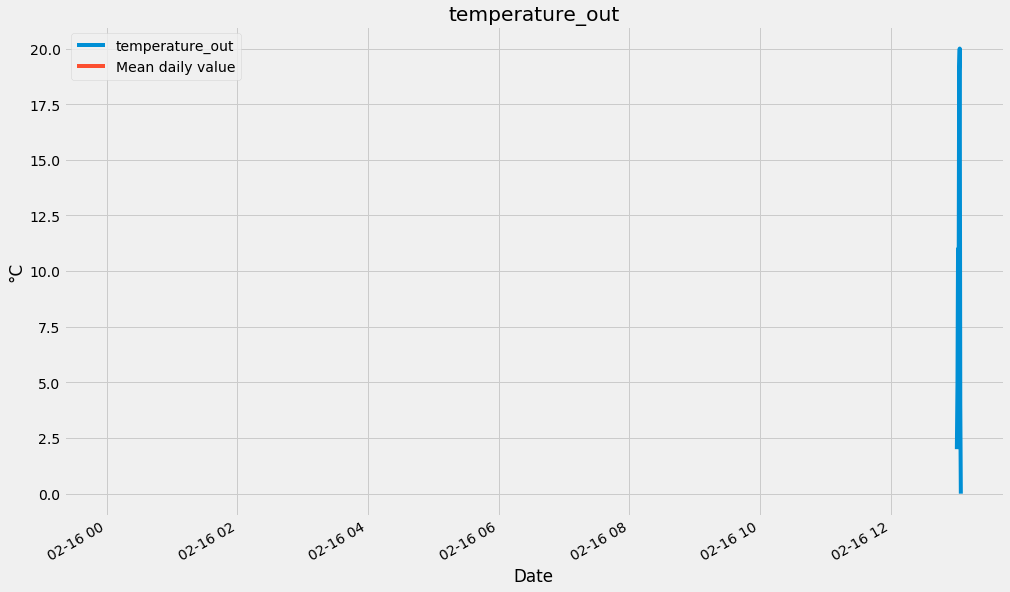

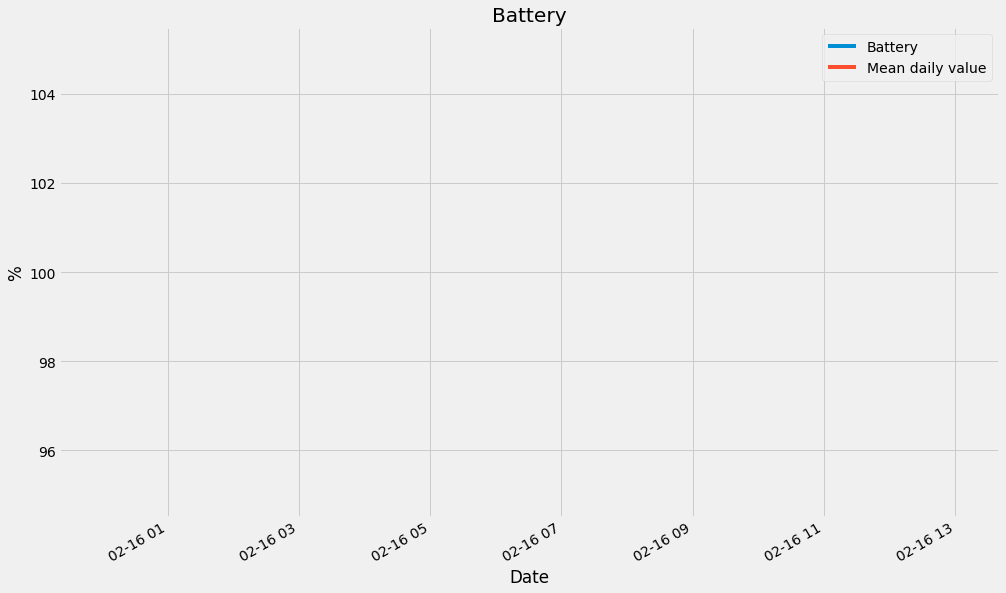

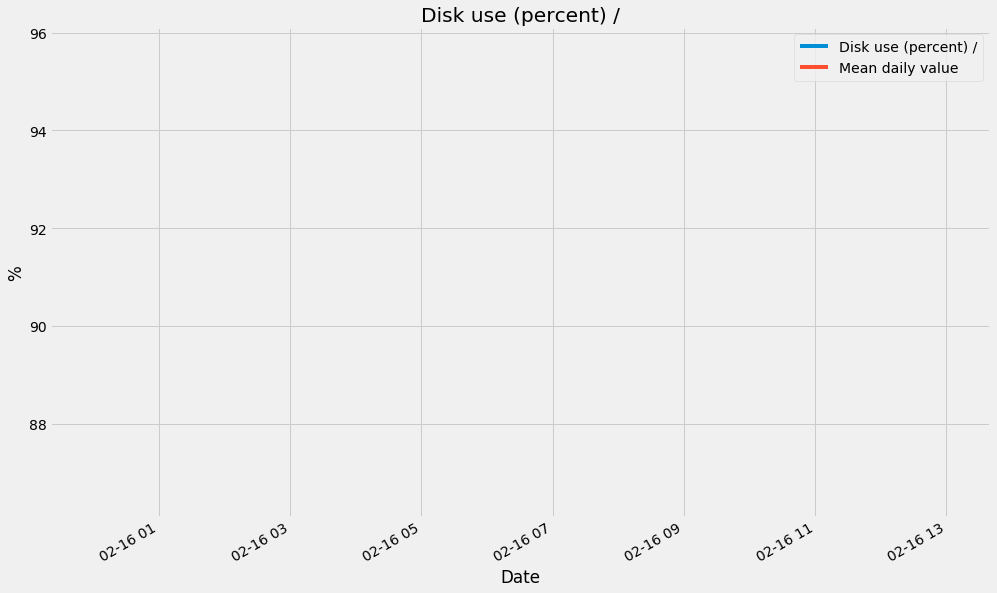

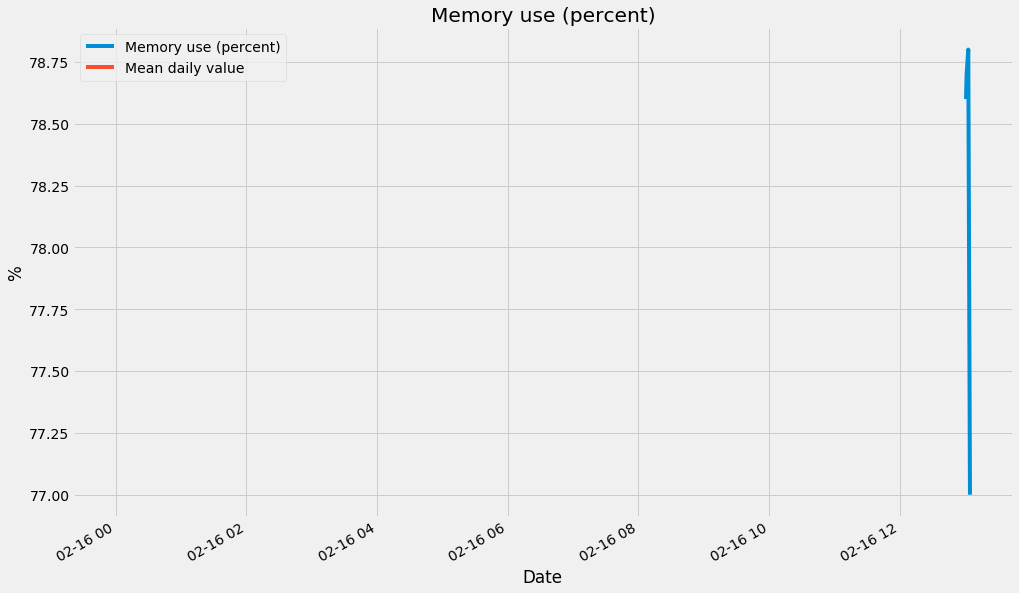

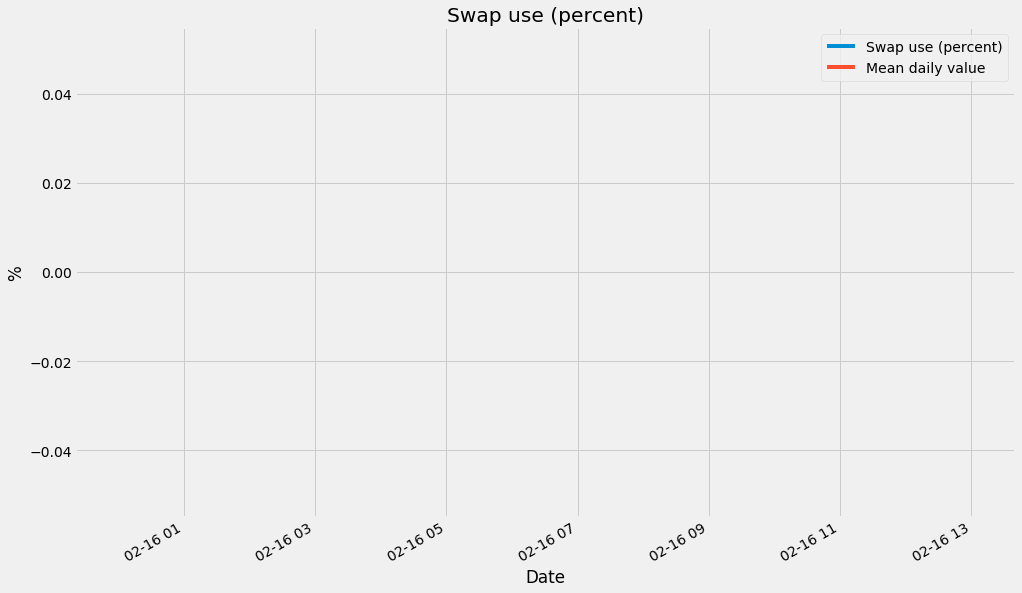

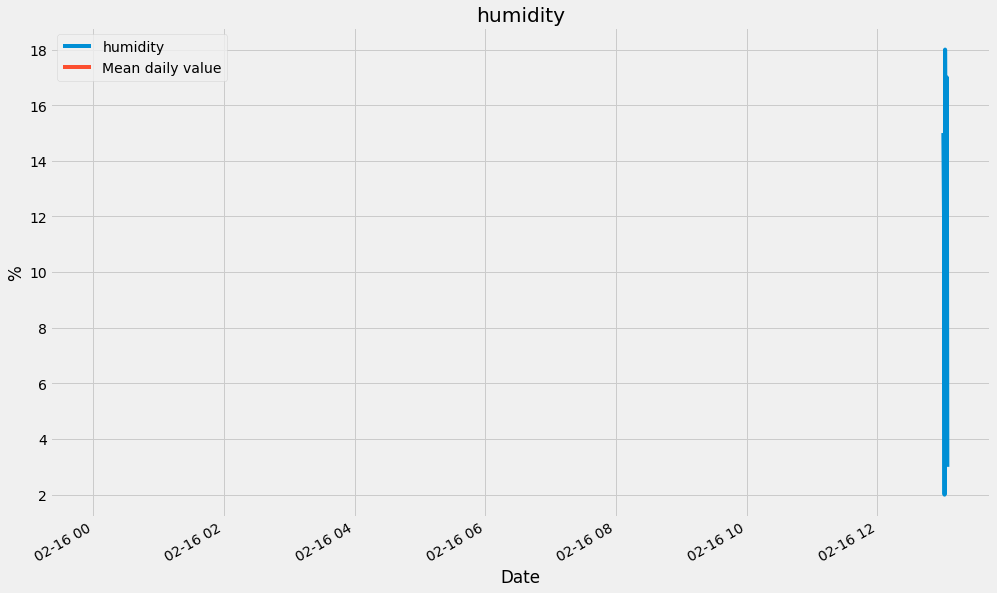

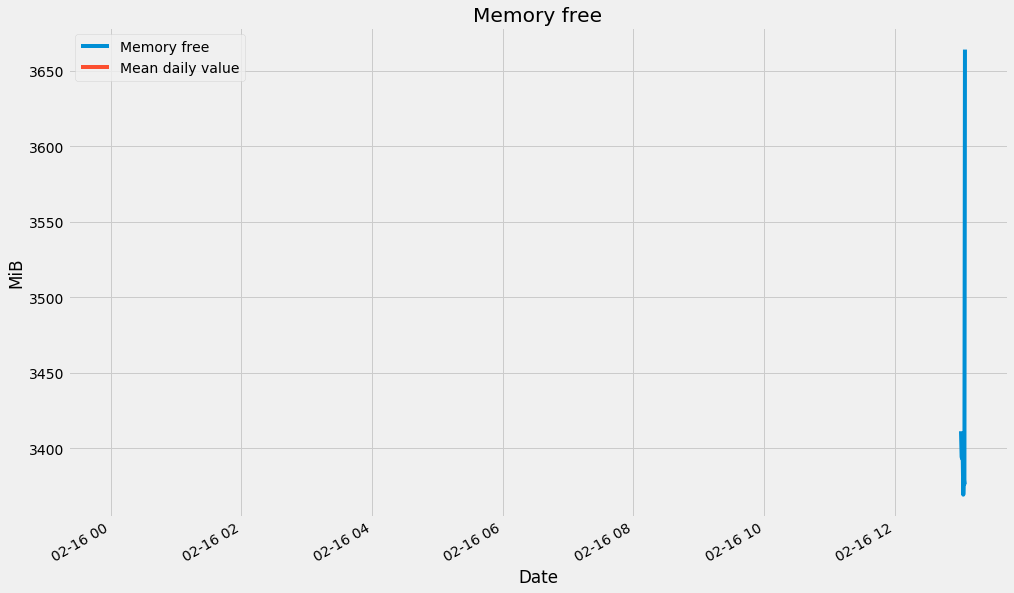

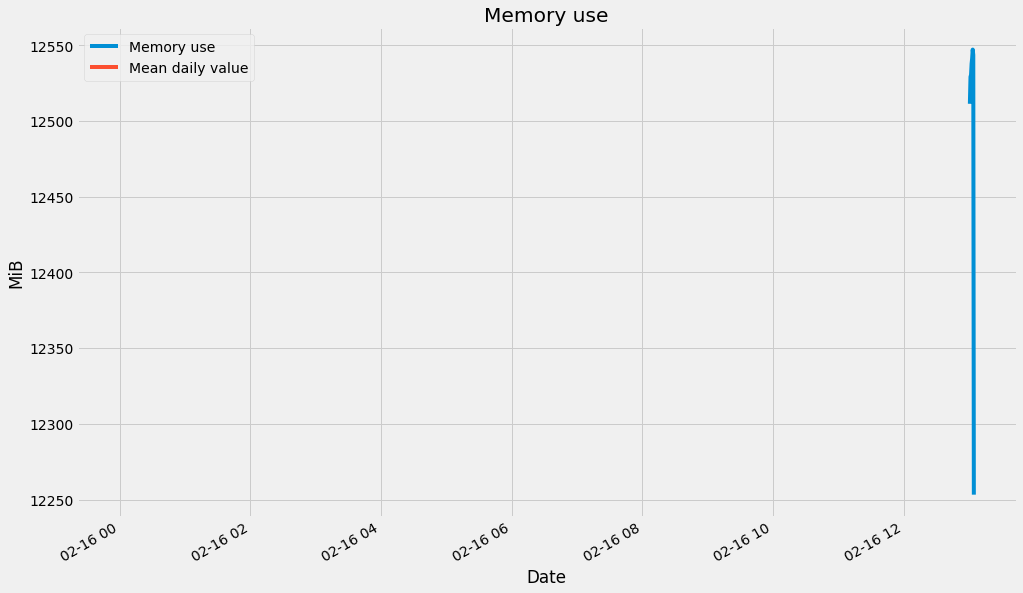

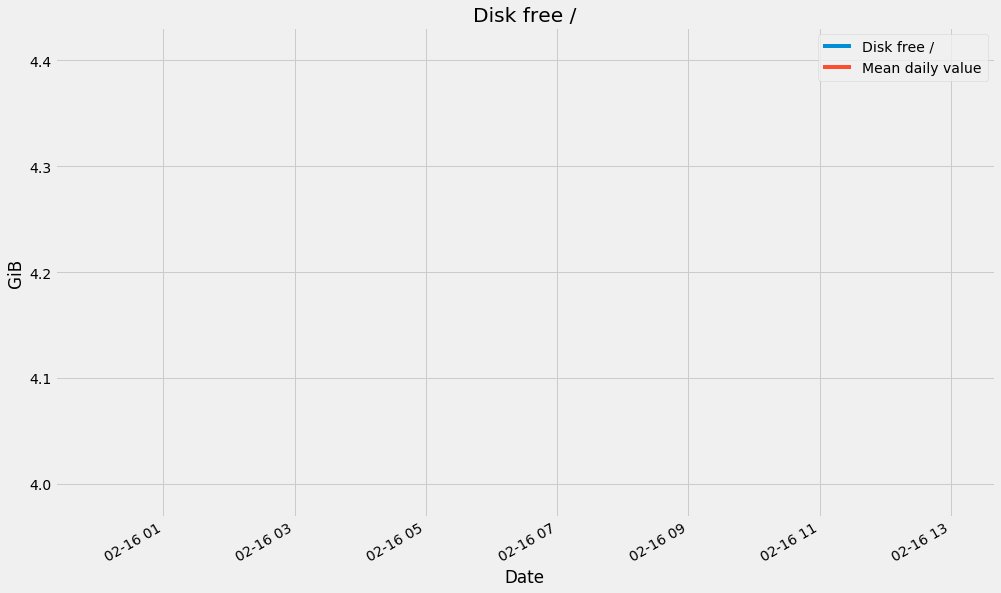

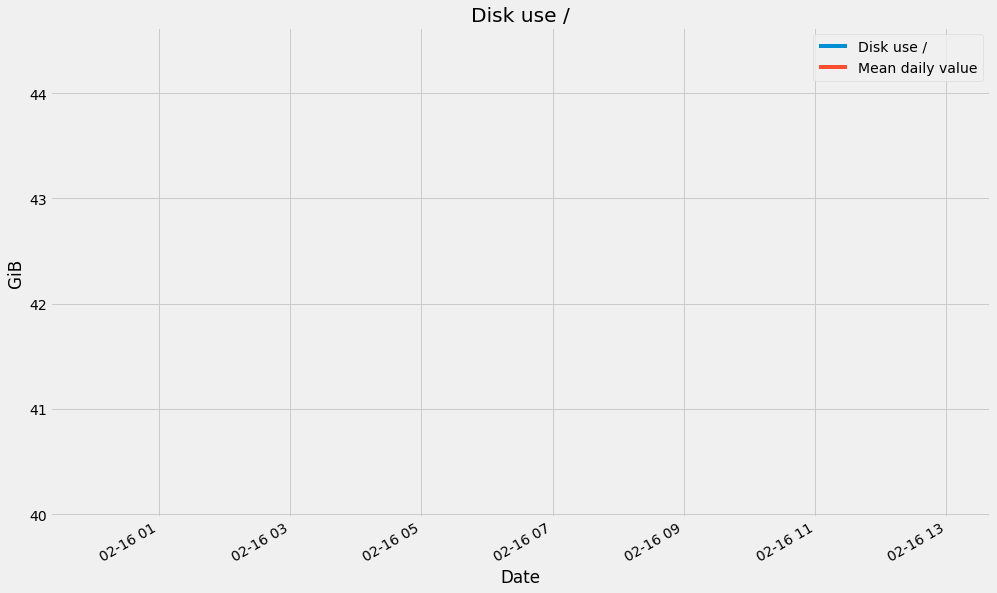

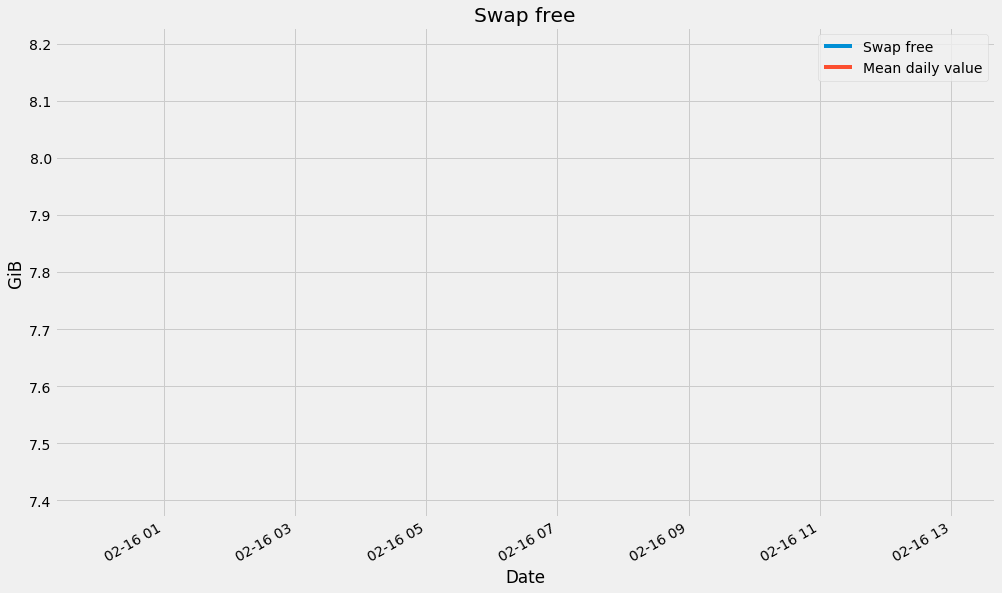

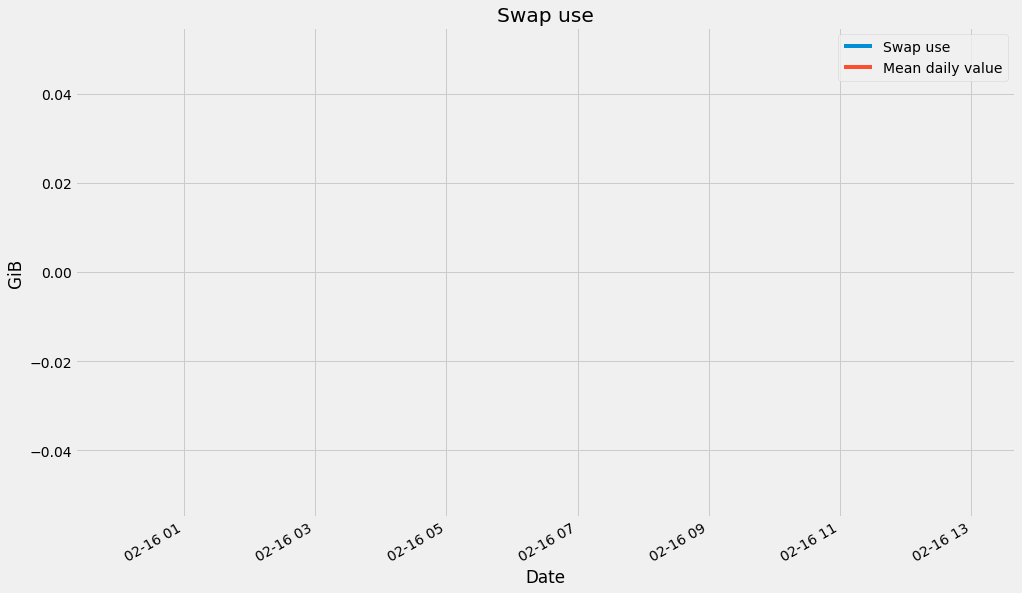

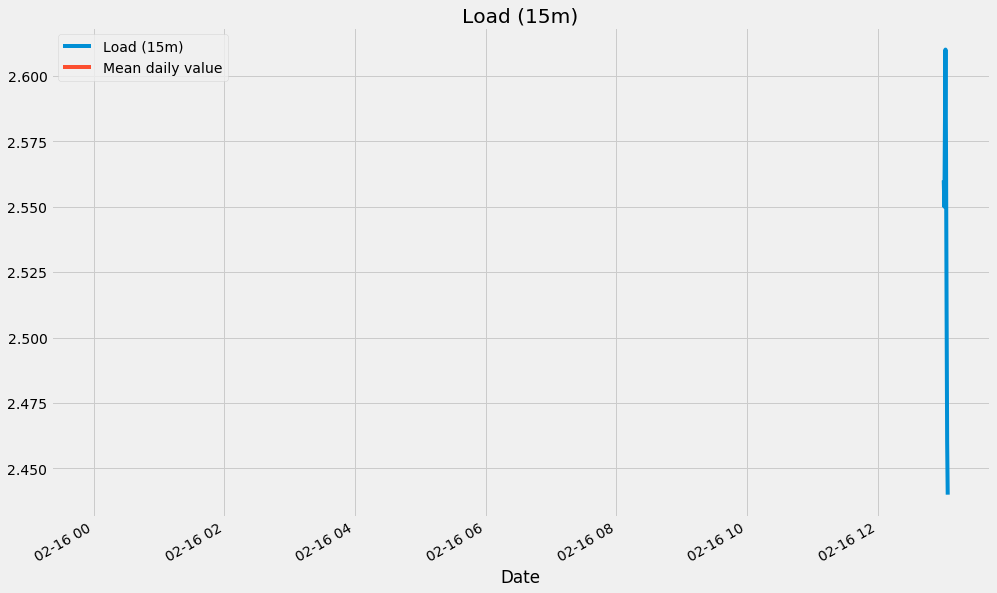

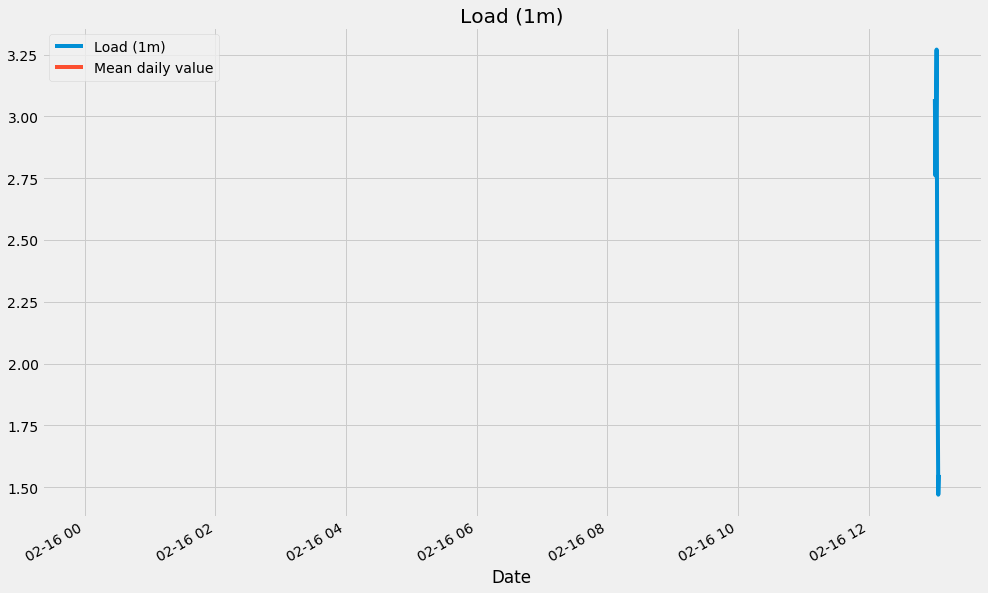

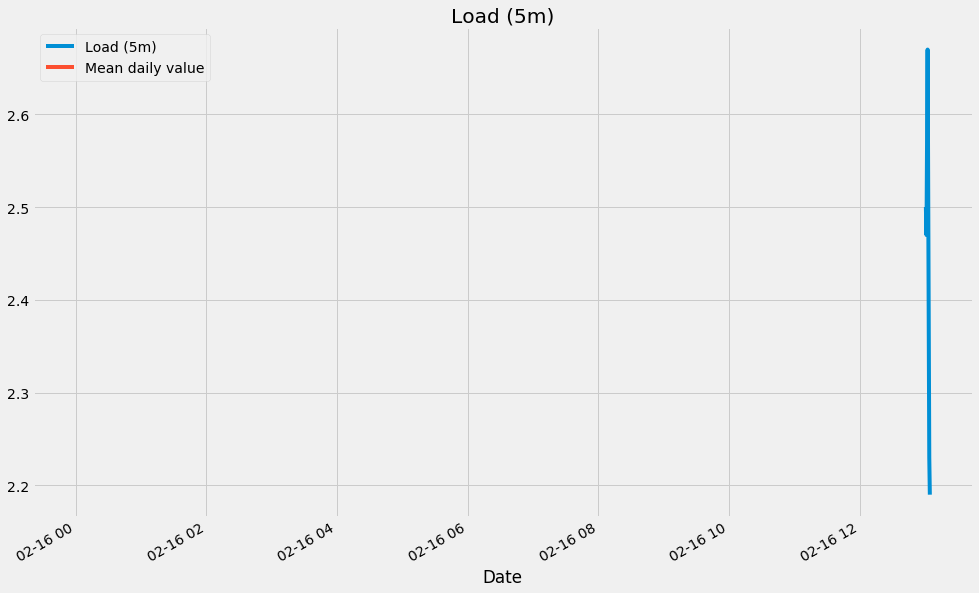

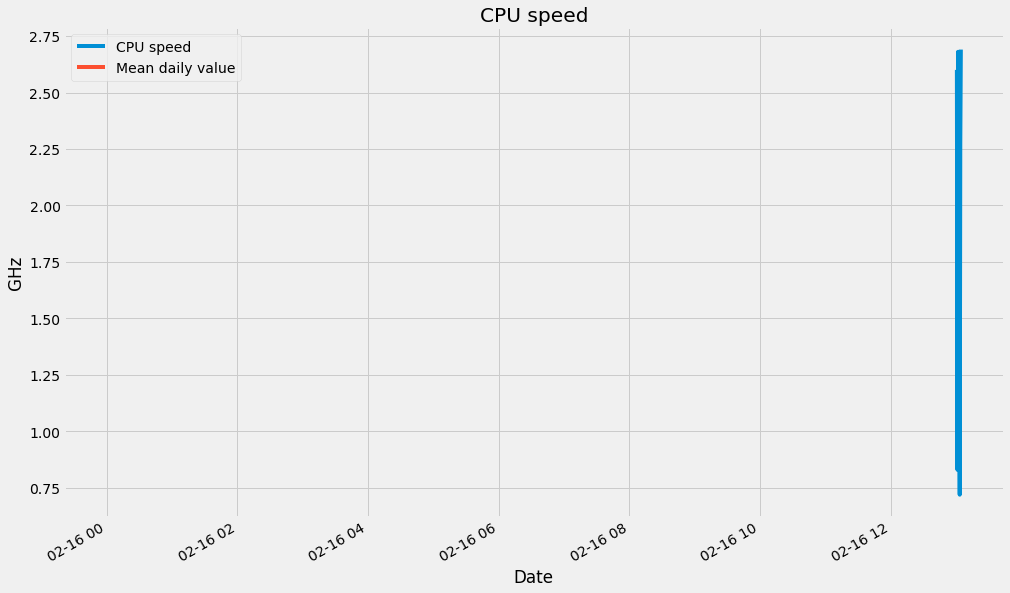

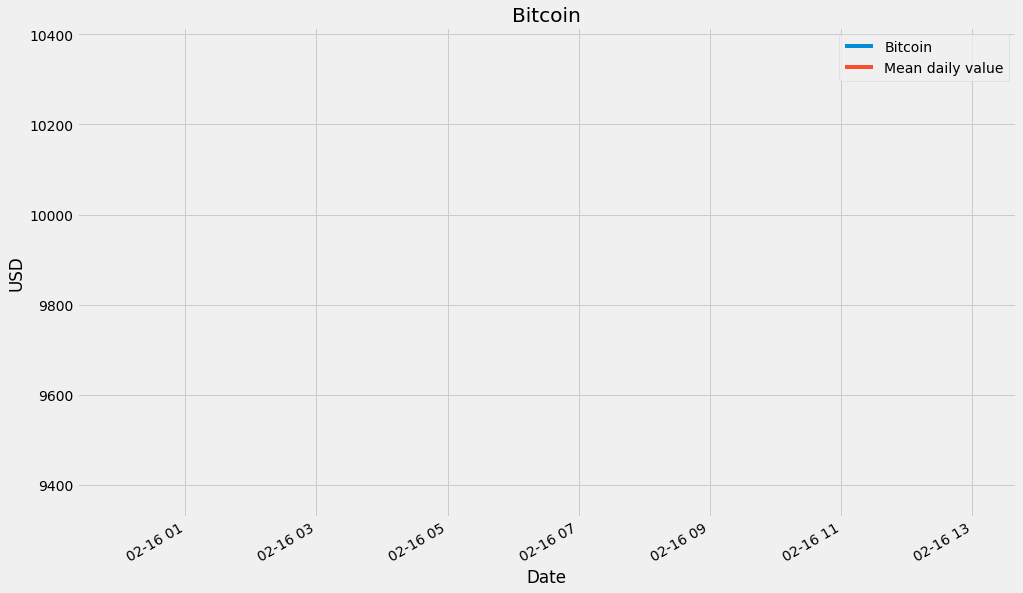

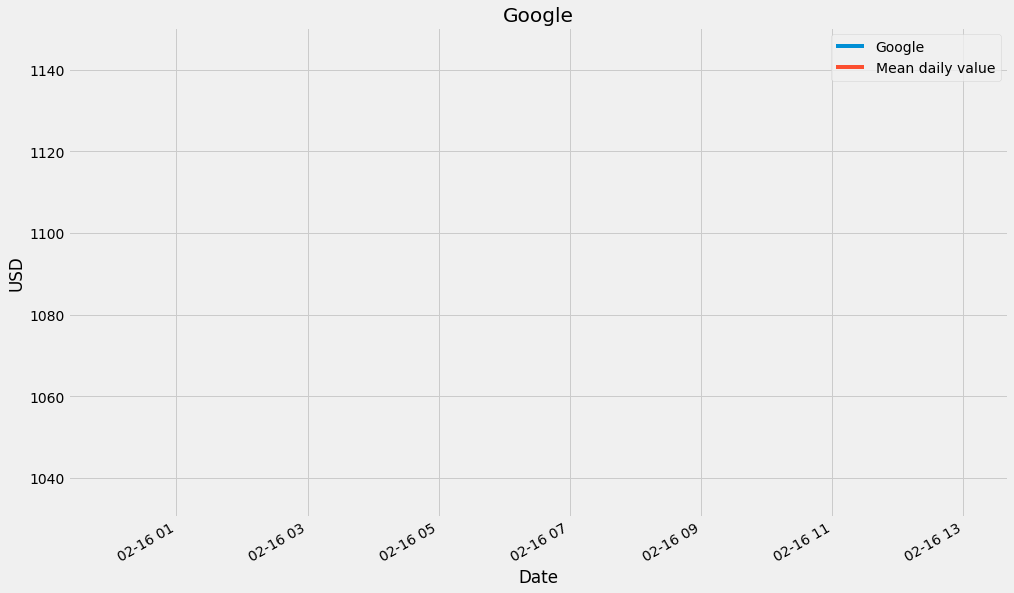

In [6]:
# Query to pull all rows form the states table where last_changed field is on
# or after the date_filter value
stmt = text("SELECT * FROM states where last_changed>=:date_filter")

# Bind parameters to the stmt value, specifying the date_filter to be 10 days
# before today
stmt = stmt.bindparams(date_filter=datetime.now()-timedelta(days=20))

# Execute the SQL statement
allquery = engine.execute(stmt)

# Get rows from query into a pandas dataframe
allqueryDF = pd.DataFrame(allquery.fetchall())

# Name the dataframe rows for usability
allqueryDF.columns = ['state_id', 'domain', 'entity_id', 'state', 'attributes',
                      'event_id', 'last_changed', 'last_updated','created']

# Split the json from the 'attributes' column and 'concat' to existing
# dataframe as separate columns
allqueryDF = pd.concat([allqueryDF, allqueryDF['attributes'].apply(json.loads)
                       .apply(pd.Series)], axis=1)

# change the last_changed datatype to datetime
allqueryDF['last_changed'] = pd.to_datetime(allqueryDF['last_changed'])

# Let's see what units of measurement there are in our database and now in
# our dataframe
print(allqueryDF['unit_of_measurement'].unique())

# Let's chart data for each of the unique units of measurement
for i in allqueryDF['unit_of_measurement'].unique():
    # Filter down our original dataset to only contain the unique unit of
    # measurement, and removing the unknown values

    # Create variable with TRUE if unit of measurement is the one being
    # processed now
    iunit = allqueryDF['unit_of_measurement'] == i

    # Create variable with TRUE if age is state is not unknown
    notunknown = allqueryDF['state'] != 'unknown'

    # Select all rows satisfying the requirement: unit_of_measurement
    # matching the current unit and not having an 'unknown' status
    cdf = allqueryDF[iunit & notunknown].copy()

    # Convert the last_changed 'object' to 'datetime' and use it as the index
    # of our new concatenated dataframe
    cdf.index = cdf['last_changed']

    # Convert the 'state' column to a float
    cdf['state'] = cdf['state'].astype(float)

    # Create a groupby object for each of the friendly_name values
    groupbyName = cdf.groupby(['friendly_name'])

    # Build a separate chart for each of the friendly_name values
    for key, group in groupbyName:

        # Since we will be plotting the 'State' column, let's rename it to
        # match the groupby key (distinct friendly_name value)
        tempgroup = group.copy()
        tempgroup.rename(columns={'state': key}, inplace=True)

        # Plot the values, specify the figure size and title
        ax = tempgroup[[key]].plot(title=key, legend=False, figsize=(15, 10))

        # create a mini-dataframe for each of the groups
        df = groupbyName.get_group(key)

        # Resample the mini-dataframe on the index for each Day, get the mean
        # and plot it
        bx = df['state'].resample('D').mean().plot(label='Mean daily value',
                                                   legend=False)

        # Set the axis labels and display the legend
        ax.set_ylabel(i)
        ax.set_xlabel('Date')
        ax.legend()